# meeting 5 anaylsis

## objectives:
1. try multiple triggers for now it is 252/63 and 60/20
2. create a table for three of them and compare the results
3. find the corrlation between our gold strategy and market


In [2]:
import pandas as pd 
import quantstats as qs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  
import warnings
warnings.filterwarnings('ignore')

In [3]:
pnl_data_path = '/Users/liubenchen/Desktop/Low-Tide-Capital-Management/data/pnl_data/XAUBNG.csv'
data =  pd.read_csv(pnl_data_path, parse_dates=['Date'])
data.columns

Index(['Date', 'Close', 'pct_change', 'sma252', 'sma63', 'sma20', 'sma60',
       'signal', 'position', 'start_time', 'equity_num', 'cash',
       'equity_value', 'net_value', 'equity_change', 'equity_curve',
       'close_pnl'],
      dtype='object')

In [4]:
mktdata = pd.read_csv('/Users/liubenchen/Desktop/Low-Tide-Capital-Management/data/pnl_data/60_40Ports.csv', parse_dates=['Date'])
mktdata.columns

Index(['Date', 'Bond', 'Stock', 'Bond_pctchange', 'Bond_pnl',
       'Stock_pctchange', 'Stock_pnl', 'ports_pctchange', 'ports_pnl'],
      dtype='object')

In [5]:
data = data.merge(mktdata[['Date', 'ports_pnl', 'ports_pctchange']], on='Date', how='left')
data.columns

Index(['Date', 'Close', 'pct_change', 'sma252', 'sma63', 'sma20', 'sma60',
       'signal', 'position', 'start_time', 'equity_num', 'cash',
       'equity_value', 'net_value', 'equity_change', 'equity_curve',
       'close_pnl', 'ports_pnl', 'ports_pctchange'],
      dtype='object')

## 1. draw the triggers in the chart

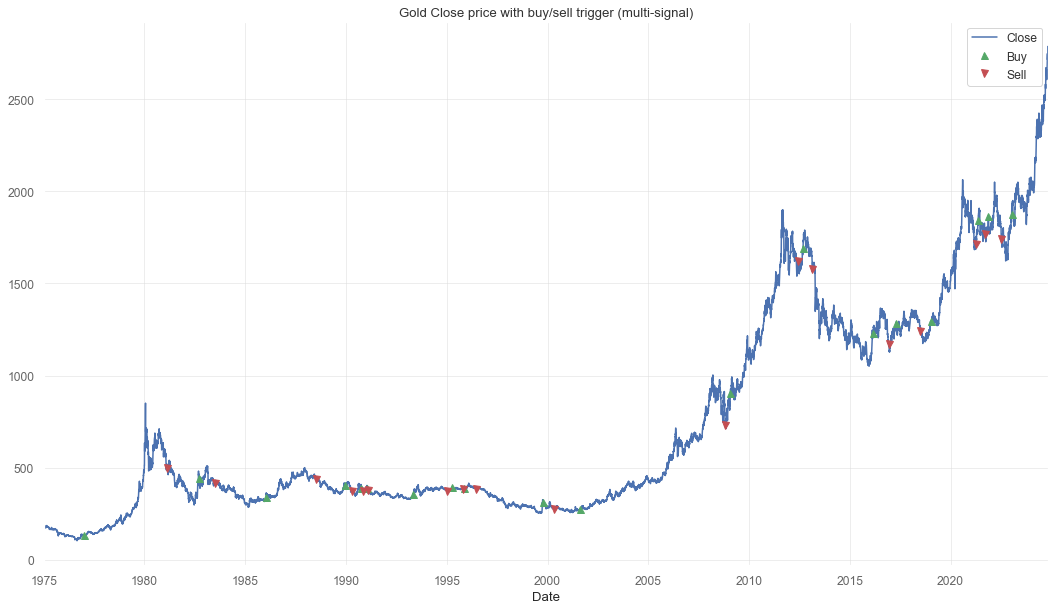

In [6]:
# plot the trigger in the data
data['trigger'] = data['signal'] - data['signal'].shift(1)
# if trigger is 1 then buy, if trigger is -1 then sell
# draw a graph about the Close price and the trigger
# and set the Date as the index
fig, ax = plt.subplots(figsize=(18, 10))
if 'Date' in data.columns:
    data.set_index('Date', inplace=True)
data['Close'].plot(ax=ax)
data['Close'][data['trigger'] == 1].plot(ax=ax, ls='', marker='^', markersize=7, color='g')
data['Close'][data['trigger'] == -1].plot(ax=ax, ls='', marker='v', markersize=7, color='r')
# add some notation
plt.legend(['Close', 'Buy', 'Sell'])
plt.title('Gold Close price with buy/sell trigger (multi-signal)')
plt.show()


In [7]:
def get_metrics(data):
    ret = {'sharp':round(qs.stats.sharpe(data, periods=12), 6),
    'avg_return':100 * round(qs.stats.avg_return(data), 6),
    'max_drawdown':100 * round(qs.stats.max_drawdown(data), 6),
    'win_rate':round(qs.stats.win_rate(data), 6),
    'calmar':round(qs.stats.calmar(data), 6),
    'volatility':round(qs.stats.volatility(data), 6),
    }
    
    annulized_return = data.mean() * 12
    ret['annulized_return'] = round(annulized_return, 6)
    return ret

## 2. static allocation about new ports and find the corr metrix

In [8]:
port_dict = {'6040Ports': data['ports_pctchange'], 'Strategy': data['equity_change'], 'Gold': data['Close'].pct_change()}
for i in [0.05, 0.1, 0.2, 0.3, 0.4]:
    port_dict[f'Mixed Ports {i}'] = data['equity_change'] * i + data['ports_pctchange']
metrics_dict = {}
for key in port_dict.keys():
    # convert to monthly data
    port_dict[key] = port_dict[key].resample('M').apply(lambda x: (x + 1).prod() - 1)
    metrics_dict[key] = get_metrics(port_dict[key])


metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,6040Ports,Strategy,Gold,Mixed Ports 0.05,Mixed Ports 0.1,Mixed Ports 0.2,Mixed Ports 0.3,Mixed Ports 0.4
sharp,1.113643,0.480828,0.386247,1.154511,1.181552,1.198022,1.177891,1.138315
avg_return,0.657400,0.992500,0.589800,0.688500,0.719600,0.781600,0.843700,0.905600
max_drawdown,-17.791600,-35.926100,-61.652800,-17.736800,-18.022200,-19.552300,-21.249500,-22.968100
win_rate,0.659432,0.539295,0.505017,0.662771,0.651085,0.646077,0.657763,0.644407
calmar,0.303747,0.121426,0.061789,0.319711,0.329231,0.329771,0.326920,0.323516
volatility,0.324629,0.699230,0.838309,0.327939,0.334890,0.358784,0.393874,0.437500
annulized_return,0.078890,0.073367,0.070658,0.082619,0.086347,0.093797,0.101240,0.108675


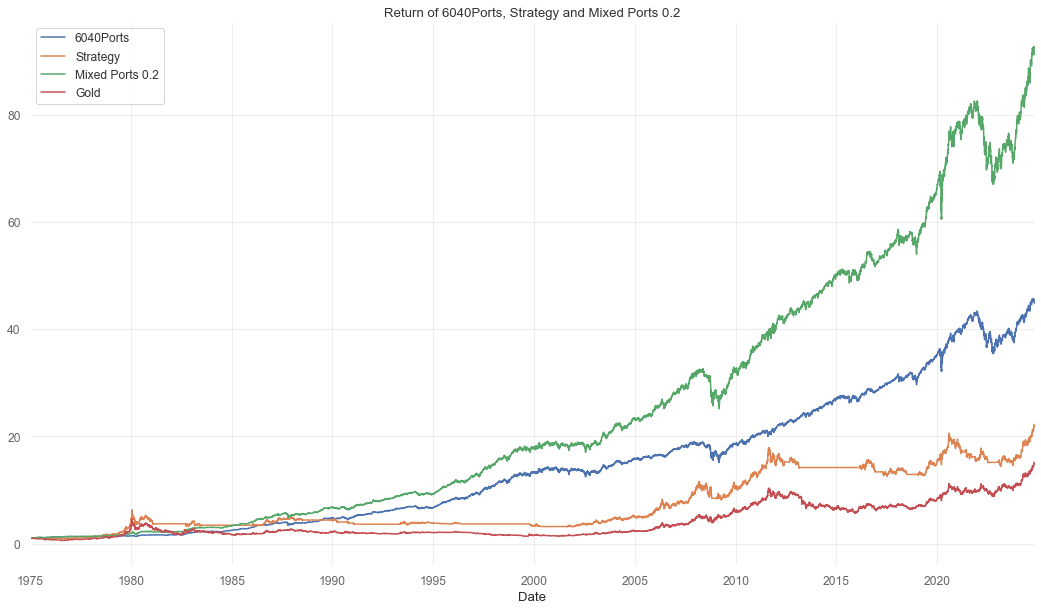

In [9]:
# draw the equity curve of 6040Ports, Strategy and Mixed Ports 0.2
specified_dict = {'6040Ports': data['ports_pctchange'], 'Strategy': data['equity_change'], 'Mixed Ports 0.2': data['equity_change'] * 0.2 + data['ports_pctchange'], 'Gold': data['Close'].pct_change()}
fig, ax = plt.subplots(figsize=(18, 10))
# calc log return
for key in specified_dict.keys():
    specified_dict[key] = specified_dict[key].apply(lambda x: (x + 1)).cumprod()
    # calc max drawdown and drawdown duration not using quantstats
    specified_dict[key].plot(ax=ax)
    
plt.legend(specified_dict.keys())
plt.title('Return of 6040Ports, Strategy and Mixed Ports 0.2')
plt.show()


<AxesSubplot:>

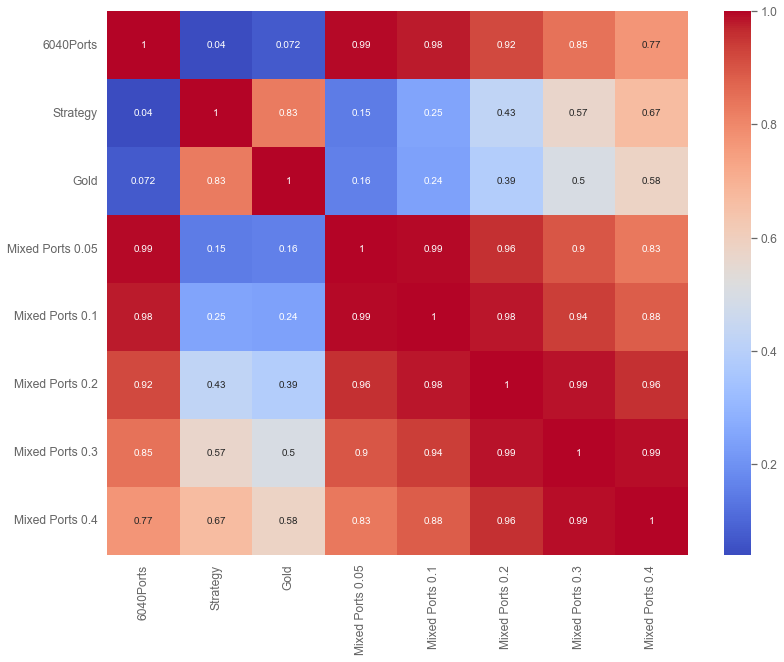

In [10]:
# plot the corrlation matrix
corr = pd.DataFrame(port_dict).corr()
figsize = (13, 10)
fig, ax = plt.subplots(figsize=figsize)
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)

# meeting 6 anaylsis
**objectives :**
1. Investigate the largest drawdown periods. When does it occur? How long does it take to recover? And what was happening to gold in that period?


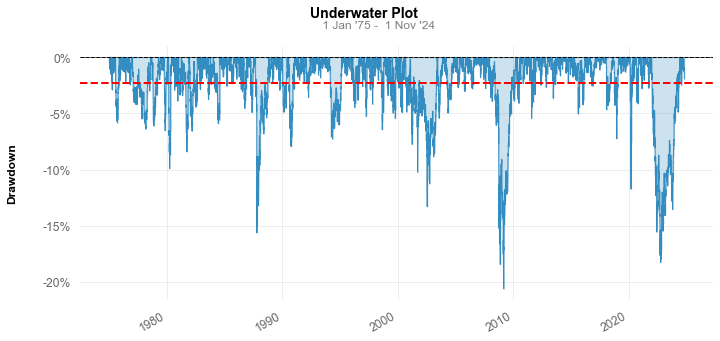

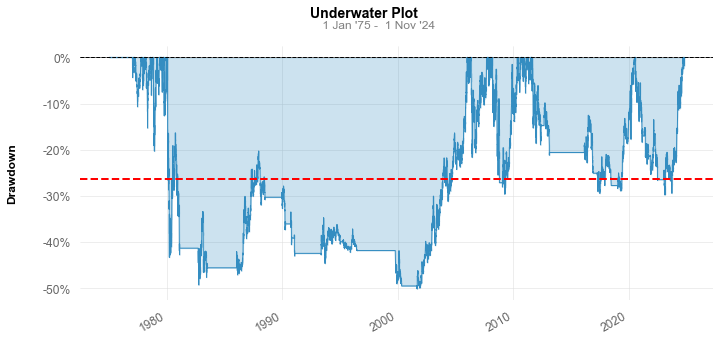

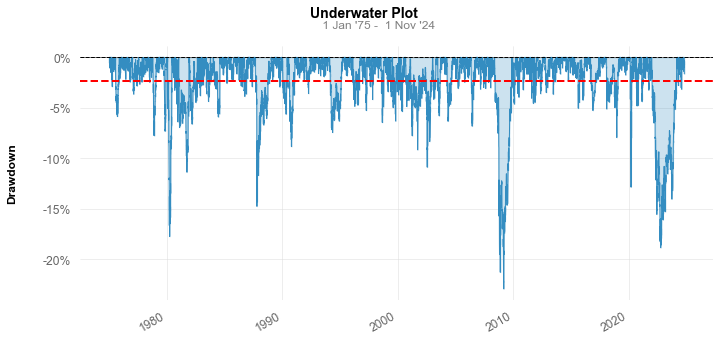

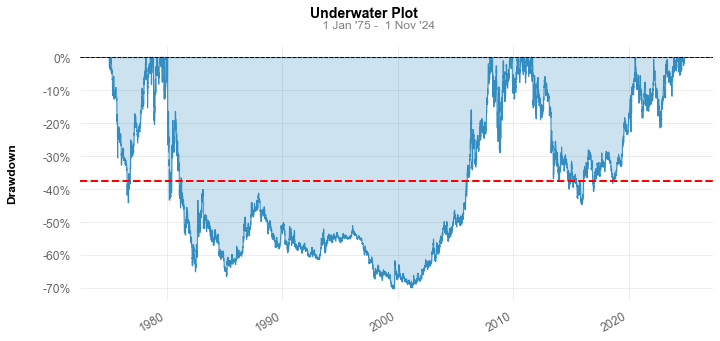

In [11]:
def maxdrawdown_details(name, data):
    qs.plots.drawdown(data, subtitle=name+' Max Drawdown')

for key, val in specified_dict.items():
    fig = maxdrawdown_details(key, val)

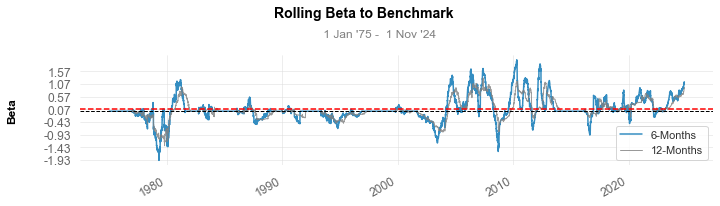

In [15]:
qs.plots.rolling_beta(data['equity_change'], data['ports_pctchange'])

In [70]:
def get_drawdown_detail(data, name):
    drawdownseries = qs.stats.to_drawdown_series(data)
    drawdown_details = qs.stats.drawdown_details(drawdown=drawdownseries)
    return drawdown_details

# use 2 level table to show the drawdown details in specified_dict
drawdown_dict = {}
for key, val in specified_dict.items():
    detail = get_drawdown_detail(val, key)
    detail.sort_values(by='max drawdown', ascending=True, inplace=True)
    detail.reset_index(inplace=True, drop=True)
    drawdown_dict[key] = detail.head(5)
# set key as the first level index, and the second level index is the drawdown details
drawdown_df = pd.concat(drawdown_dict, axis=0)
drawdown_df

start      valley         end   days  max drawdown  \
6040Ports       0  2007-12-07  2009-03-09  2010-03-22    837    -20.631417   
                1  2021-12-28  2022-10-14  2024-06-12    898    -18.270532   
                2  1987-08-26  1987-10-19  1988-10-28    430    -15.641883   
                3  2000-09-05  2002-07-23  2003-06-02   1001    -13.304866   
                4  2020-02-21  2020-03-23  2020-05-26     96    -11.741381   
Strategy        0  1980-01-22  2001-09-04  2006-01-06   9482    -50.169630   
                1  2020-08-07  2023-02-24  2024-09-13   1499    -29.828475   
                2  2008-03-17  2009-04-17  2010-05-11    786    -29.617514   
                3  2011-09-06  2017-07-07  2020-07-06   3227    -29.495415   
                4  2006-05-15  2006-06-14  2007-09-14    488    -21.691381   
Mixed Ports 0.2 0  2008-05-21  2009-03-09  2009-11-24    553    -22.906635   
                1  2021-12-28  2022-10-14  2024-03-19    813    -18.835835   
                2  1980-01-22  1980-03-27  1980-06-06    137    -17.720156   
                3  1987-08-26  1987-10-19  1989-01-17    511    -14.739324   
                4  2020-02-24  2020-03-20  2020-04-28     65    -12.840860   
Gold            0  1980-01-22  1999-08-25  2008-01-01  10207    -70.288235   
                1  2011-09-06  2015-12-17  2020-07-23   3244    -44.684770   
                2  1975-02-25  1976-08-25  1978-03-06   1106    -44.129555   
                3  2008-03-17  2008-11-12  2009-09-10    543    -28.980955   
                4  2020-08-07  2022-09-26  2023-11-30   1211    -21.379765   

                   99% max drawdown  
6040Ports       0        -18.834587  
                1        -17.502795  
                2        -13.842463  
                3        -10.827908  
                4        -11.440224  
Strategy        0        -49.509260  
                1        -29.053932  
                2        -28.580640  
                3        -28.608260  
                4        -19.837716  
Mixed Ports 0.2 0        -21.832614  
                1        -18.096837  
                2        -16.835865  
                3        -13.364255  
                4        -12.779148  
Gold            0        -69.464706  
                1        -43.543837  
                2        -42.456140  
                3        -27.161232  
                4        -20.289406